In [ ]:
install.packages(c("tidyverse", "tsibble", "fable", "forecast", "ggplot2","Metrics","TSA","MASS"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘BH’, ‘progressr’, ‘ggdist’, ‘numDeriv’, ‘quadprog’, ‘quantmod’, ‘anytime’, ‘fabletools’, ‘distributional’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘zoo’, ‘RcppArmadillo’, ‘leaps’, ‘locfit’




## THe code for dataset if needed (i cant use it since it is in python )
# thes ample link for kaggle (https://www.kaggle.com/datasets/ayushnitb/tourist-numbers-univariate-forecasting-dataset )

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = ""

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ayushnitb/tourist-numbers-univariate-forecasting-dataset",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

project about forcasting the avenue of tourist in an island over 25 years

# **Introduction**

Tourism plays a crucial role in the economic development of many countries, influencing local businesses, employment, and infrastructure planning. This dataset provides detailed records of tourist arrivals to an island, offering valuable insights into visitor trends over time. Understanding these patterns is essential for local authorities and stakeholders to anticipate fluctuations in tourism, optimize resource allocation, and enhance infrastructure to improve the overall visitor experience.

The primary objective of this dataset is to forecast future tourist arrivals, allowing for better preparation during peak seasons and ensuring a sustainable tourism strategy. Accurate predictions help decision-makers implement policies that maximize economic benefits while maintaining a balanced and enjoyable environment for both tourists and residents. By leveraging historical data, this project aims to develop a reliable forecasting model that supports data-driven decision-making in tourism management.

In [ ]:
library(ggplot2)
library(forecast)
library(tseries)
library(lubridate)
library(dplyr)
library(TSA)

ERROR: Error in library(forecast): there is no package called ‘forecast’


# Preprossessing and analysing the data

In [ ]:


data <- read.csv("data.csv", header=TRUE)
colnames(data) <- c("Date", "TouristNumber")


data$Date <- as.Date(data$Date, origin = "1900-01-01")

# frequency is set to 12 since we colect information every mouth
ts_data <- ts(data$TouristNumber, start=c(1,1), frequency=12)


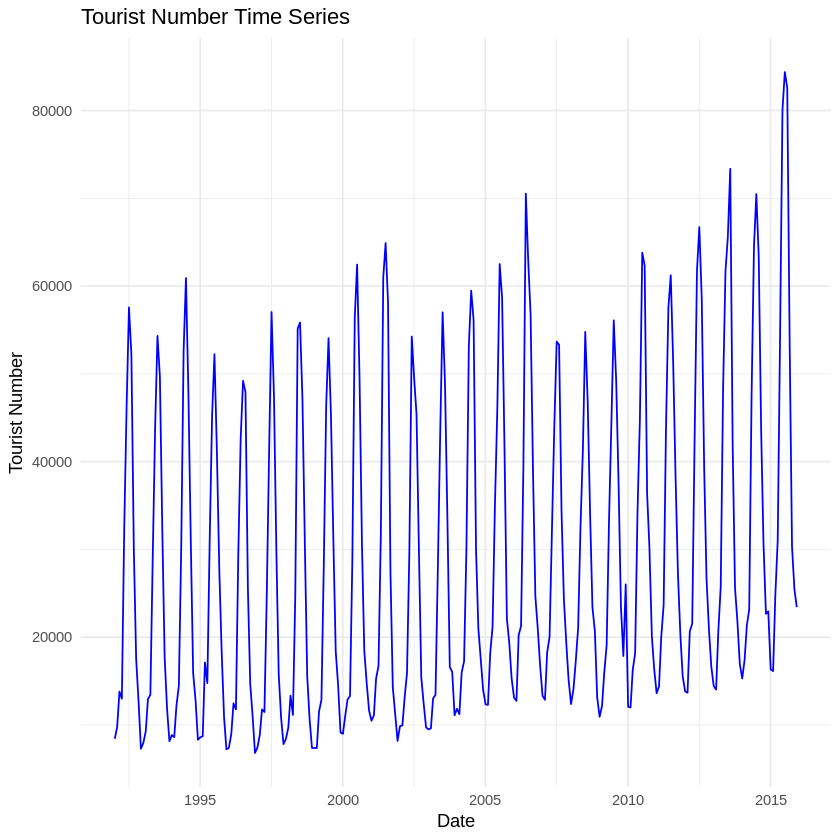

In [ ]:
# Plot the time series
ggplot(data, aes(x=Date, y=TouristNumber)) +
  geom_line(color="blue") +
  labs(title="Tourist Number Time Series", x="Date", y="Tourist Number") +
  theme_minimal()

In [ ]:
summary(data)

      Date            TouristNumber  
 Min.   :1992-01-03   Min.   : 6808  
 1st Qu.:1997-12-26   1st Qu.:13311  
 Median :2003-12-18   Median :21290  
 Mean   :2003-12-18   Mean   :28504  
 3rd Qu.:2009-12-10   3rd Qu.:43674  
 Max.   :2015-12-03   Max.   :84381  

When plotting the time series, we observe a clear seasonal pattern with a period of 12 months. Additionally, the mean shows a slow upward trend, indicating that the data is not stationary. However, the variance appears to remain relatively constant.

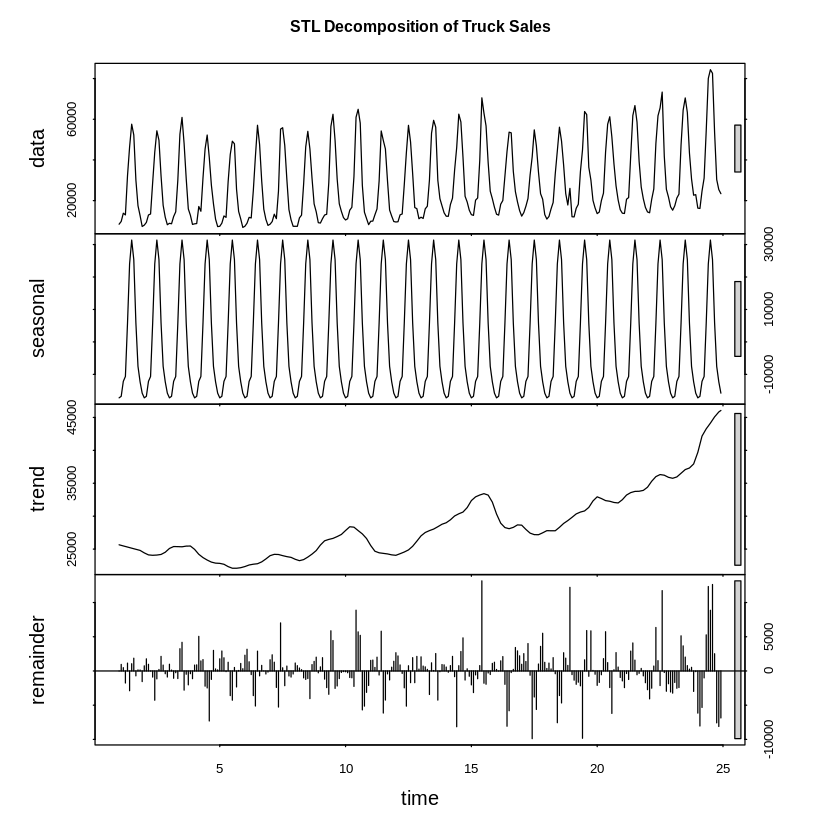

In [ ]:
see_data <- stl(ts_data, s.window = 'periodic')
plot(see_data, main = 'STL Decomposition of Truck Sales')

we clearly see season and increasing ternd in our data and the residuals aapear to be white noise

***confirming our assemptions using test and plot***

In [ ]:
adf_test <- adf.test(ts_data)
print(adf_test)


Warning message in adf.test(ts_data):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data
Dickey-Fuller = -14.25, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary



using this  test we see that 0.01 < 0.05 so the data is likly stationary and the large negative value in Dickey-Fuller = -14.25  indicate that the stationarity is strong

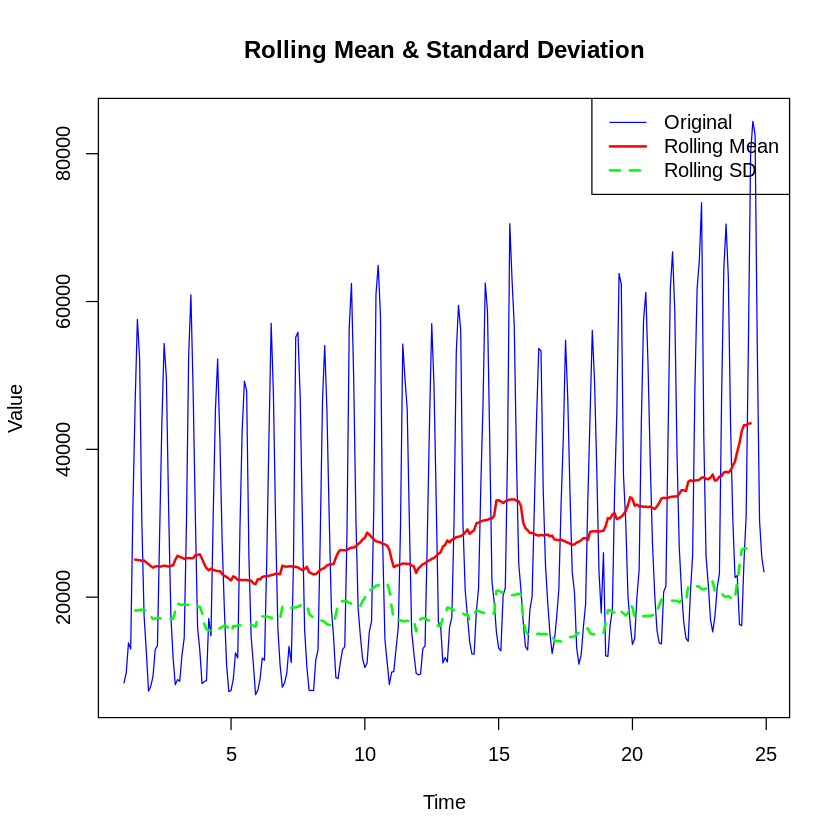

In [ ]:
#using rooling mean and roulling sd to confirm

library(zoo)

rolling_mean <- rollmean(ts_data, k = 12, fill = NA)
rolling_sd <- rollapply(ts_data, width = 12, FUN = sd, fill = NA)

plot(ts_data, col = "blue", main = "Rolling Mean & Standard Deviation", ylab = "Value", xlab = "Time")
lines(rolling_mean, col = "red", lwd = 2)  # Rolling Mean
lines(rolling_sd, col = "green", lwd = 2, lty = 2)  # Rolling SD
legend("topright", legend = c("Original", "Rolling Mean", "Rolling SD"),
       col = c("blue", "red", "green"), lty = c(1,1,2), lwd = c(1,2,2))


In [ ]:
# to check if it is trend stationary we apply Kwiatkowski-Phillips-Schmidt-Shin test
kpss.test(ts_data)



	KPSS Test for Level Stationarity

data:  ts_data
KPSS Level = 0.71282, Truncation lag parameter = 5, p-value = 0.01238


a p value < 0.05 mean the assemption that the data is trend stationary is false so Data is not trend-stationary, differencing is needed.

in the plot we clearly see that the roulling mean and rouliling sd are not stable which indicate no stationary data


plus using the Kwiatkowski-Phillips-Schmidt-Shin test we conclude that the data is not trend stationary this test see if there is deterministic trend and the test found it

The adf test suggest the revese that data is stationary but it test just the unit root and it dindt find any stockastic trend  so we say that our data doesnt have a stockastic trend

so we conclude that the data is not stationary (mean and variance not fix) since there is a deterministic trend but there is no statistick one

# using box cox

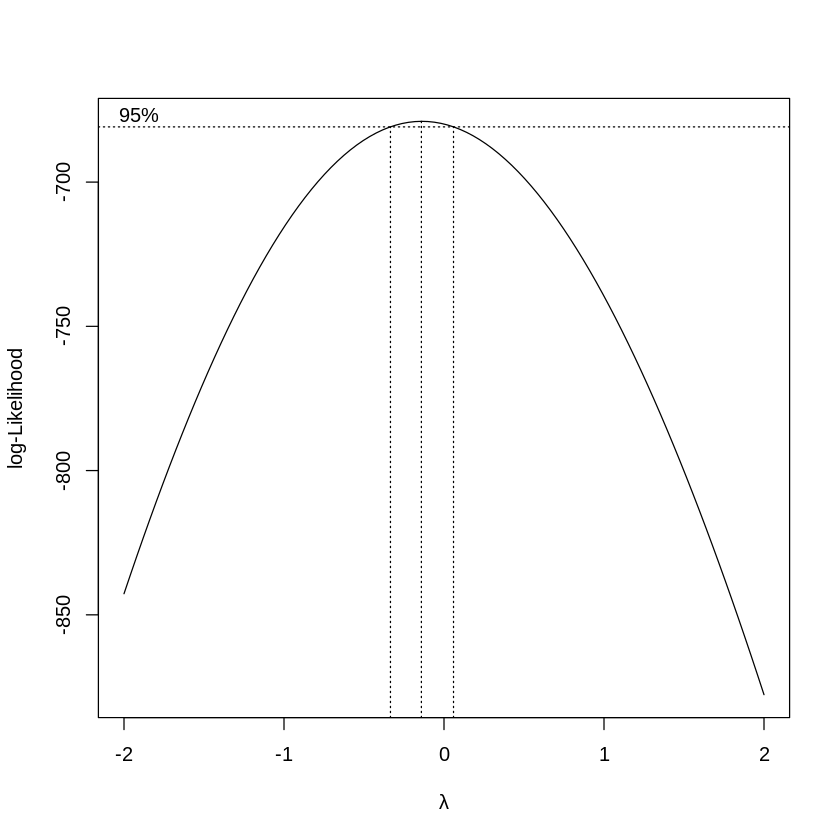

In [ ]:

library(MASS)

time <- 1:length(ts_data)


model <- lm(ts_data ~ time)
boxcox(model, lambda = seq(-2, 2, 0.1), plotit = TRUE)

In [ ]:
lambda <- BoxCox.lambda(ts_data, method = "guerrero")
print(lambda)

[1] 0.472953


so we can conclude that the optimal lambda = 0.5 so we will aply the
 square root transformation

In [ ]:
ts_data_log <- sqrt(ts_data)

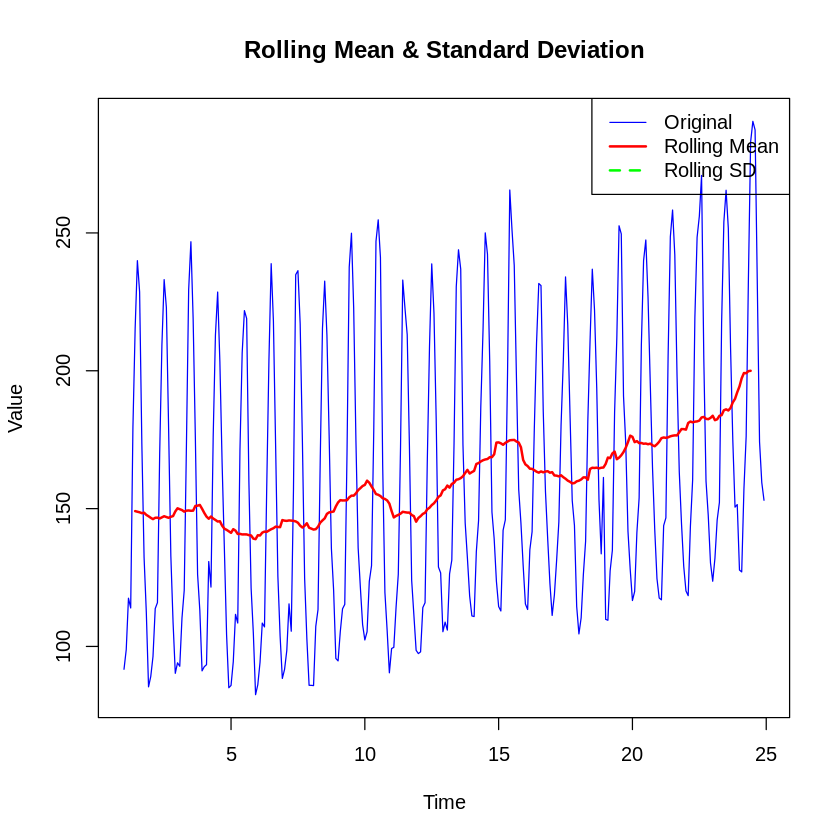

In [ ]:
#using rooling mean and roulling sd to confirm

library(zoo)

rolling_mean <- rollmean(ts_data_log, k = 12, fill = NA)
rolling_sd <- rollapply(ts_data_log, width = 12, FUN = sd, fill = NA)

plot(ts_data_log, col = "blue", main = "Rolling Mean & Standard Deviation", ylab = "Value", xlab = "Time")
lines(rolling_mean, col = "red", lwd = 2)  # Rolling Mean
lines(rolling_sd, col = "green", lwd = 2, lty = 2)  # Rolling SD
legend("topright", legend = c("Original", "Rolling Mean", "Rolling SD"),
       col = c("blue", "red", "green"), lty = c(1,1,2), lwd = c(1,2,2))


In [ ]:
# to check if it became astationary
kpss.test(ts_data_log)
adf.test(ts_data_log)

Warning message in kpss.test(ts_data_log):
“p-value smaller than printed p-value”



	KPSS Test for Level Stationarity

data:  ts_data_log
KPSS Level = 0.80352, Truncation lag parameter = 5, p-value = 0.01


Warning message in adf.test(ts_data_log):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data_log
Dickey-Fuller = -15.088, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


we clearly see that after our transformation the data is stil not trend stationary and confirmed whith the test kssp with the p < 0.05

# choosing our model

we will use 3 main methodd to decide which one is the best

1.   fiding paramters using acf and pacf
2.   using bic
3.   using auto.arima()








# using acf and pacf

finding the **d** value

since our data is not stationary we see which value of d is the best

In [ ]:
# choosing d=1

dif1_data <- diff(ts_data, differences = 1)
ts_data_log <- ts(dif1_data)

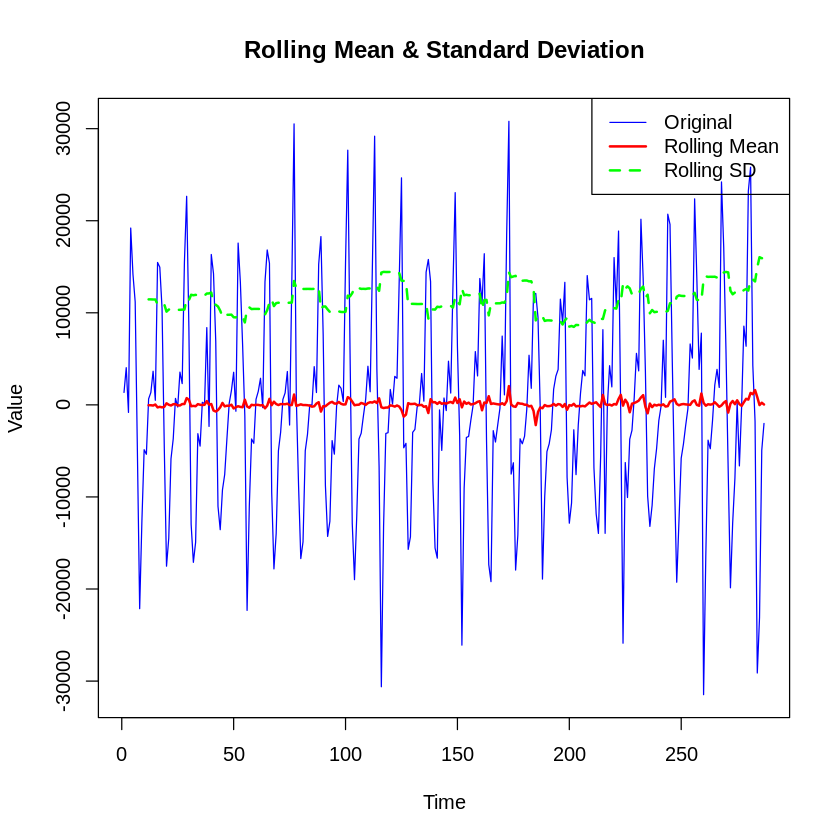

In [ ]:
library(zoo)


rolling_mean <- rollmean(ts_data_log, k = 12, fill = NA, align = "right")
rolling_sd <- rollapply(ts_data_log, width = 12, FUN = sd, fill = NA, align = "right")


plot(ts_data_log, col = "blue", main = "Rolling Mean & Standard Deviation",
     ylab = "Value", xlab = "Time")


lines(rolling_mean, col = "red", lwd = 2)
lines(rolling_sd, col = "green", lwd = 2, lty = 2)


legend("topright", legend = c("Original", "Rolling Mean", "Rolling SD"),
       col = c("blue", "red", "green"), lty = c(1, 1, 2), lwd = c(1, 2, 2))


In [ ]:
# to check if it is trend stationary we apply Kwiatkowski-Phillips-Schmidt-Shin test
kpss.test(ts_data_log)
adf.test(ts_data_log)

Warning message in kpss.test(ts_data_log):
“p-value greater than printed p-value”



	KPSS Test for Level Stationarity

data:  ts_data_log
KPSS Level = 0.0090521, Truncation lag parameter = 5, p-value = 0.1


Warning message in adf.test(ts_data_log):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data_log
Dickey-Fuller = -13.316, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


We observe that the data becomes  stationary after applying the first difference where all deterministic and stockastic trend were removed.

Therefore, there is no need to differentiate further, as it may introduce unnecessary noise.

So, we set d = 1.

**finding p and q**

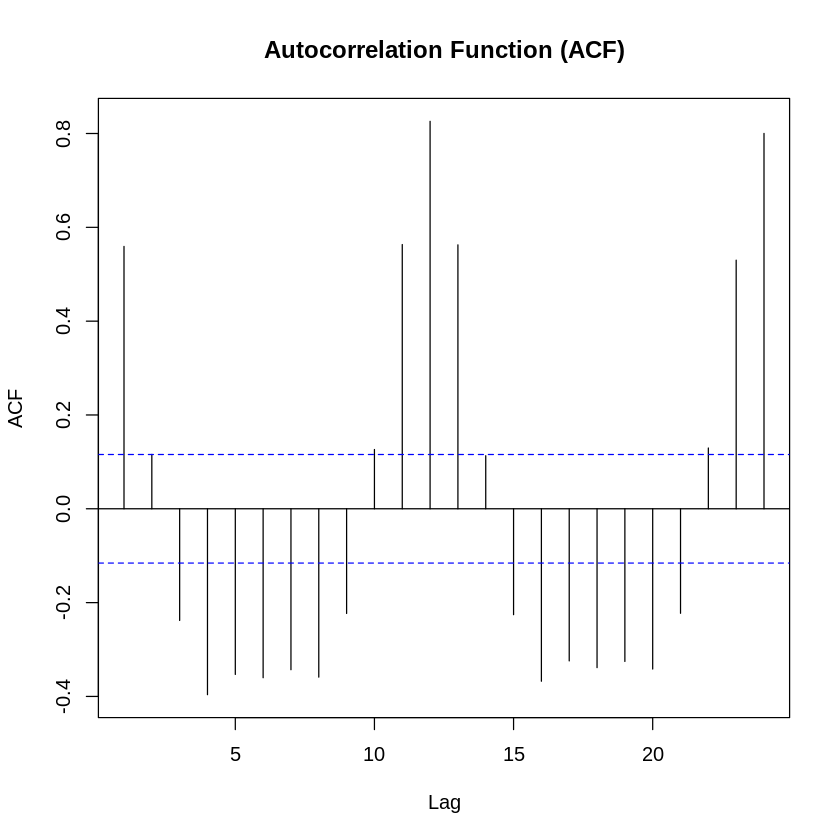

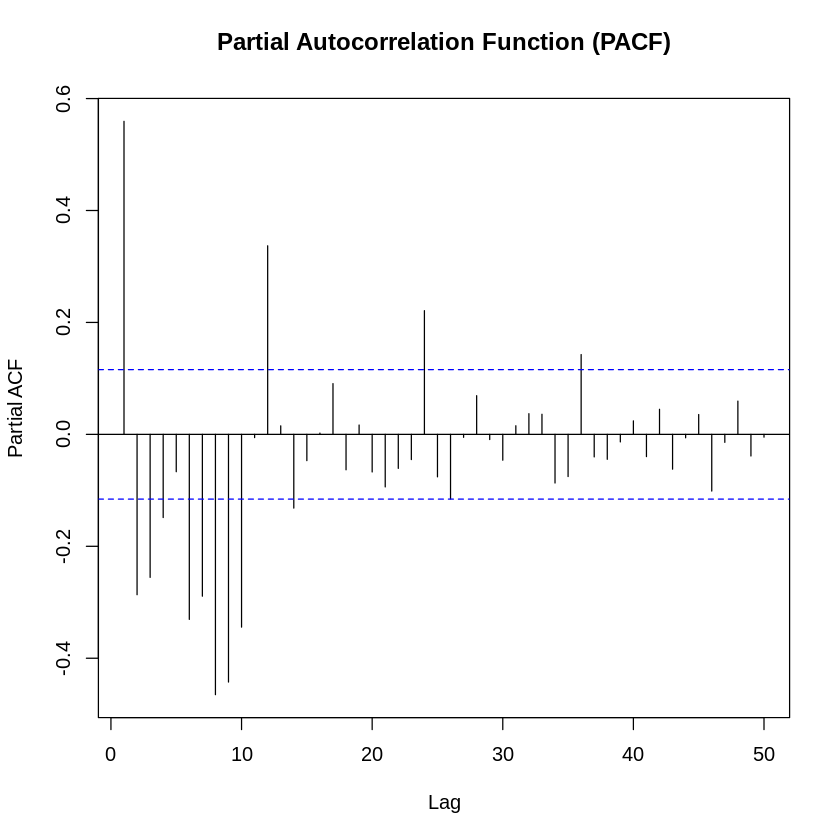

In [ ]:
# Plot ACF (Autocorrelation Function)
acf(ts_data_log, main="Autocorrelation Function (ACF)"  )

# Plot PACF (Partial Autocorrelation Function)
pacf(ts_data_log, main="Partial Autocorrelation Function (PACF)", lag.max = 50)


From the ACF plot, we observe that most of the information is captured at lag 1. Since lag indexing starts from 0, we set q = 1.

From the PACF plot, we see that the model captures most of the information at lag 3 then it s go down then up untill 10 but we can keep 3 as our first test, so we set p = 3

fiding s :
we cann se learly from the acf that at each 12 step the value is at it max which may suggest that s =12
so let us differance at s = 12 and see the result

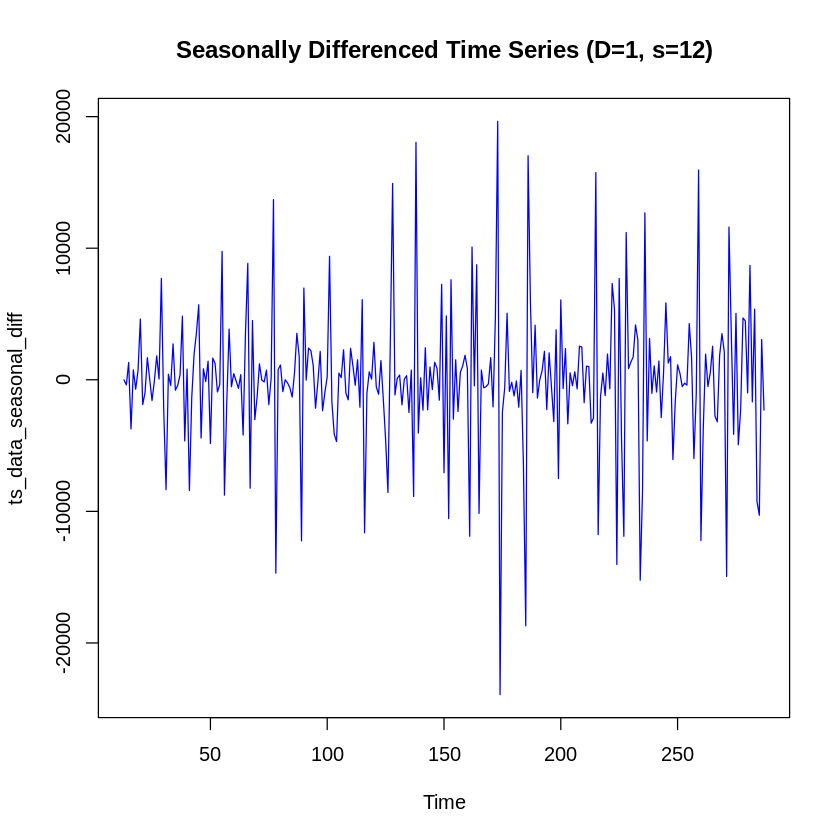

In [ ]:
ts_data_seasonal_diff <- diff(ts_data_log, lag=12, differences=1)
plot(ts_data_seasonal_diff, main="Seasonally Differenced Time Series (D=1, s=12)", col="blue")

In [ ]:
library(tseries)
adf.test(ts_data_seasonal_diff)


Warning message in adf.test(ts_data_seasonal_diff):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_data_seasonal_diff
Dickey-Fuller = -10.702, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


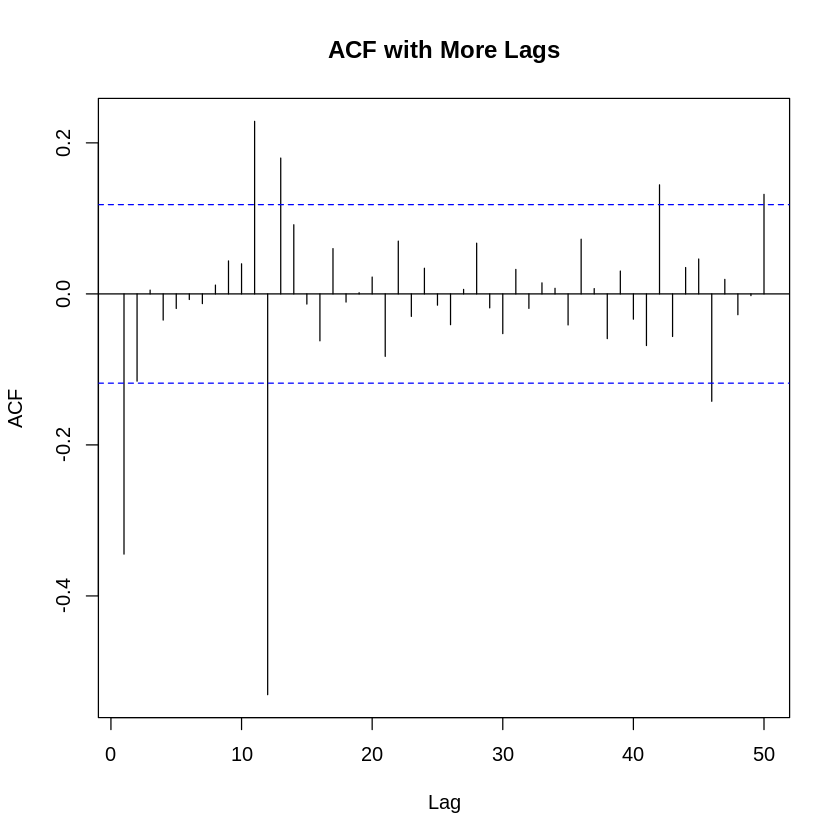

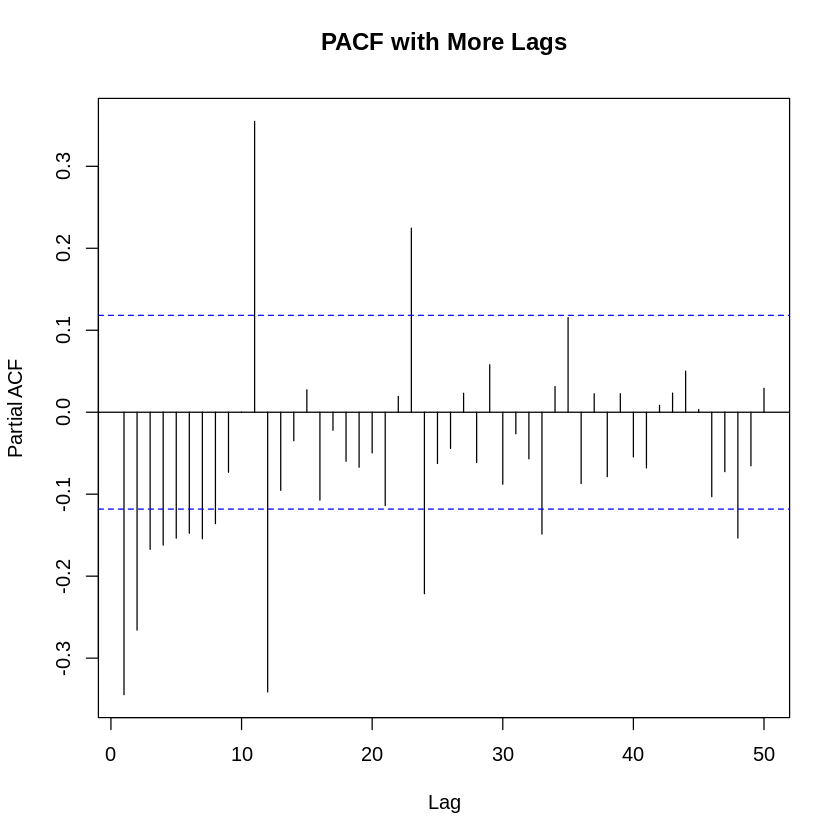

In [ ]:
acf(ts_data_seasonal_diff, lag.max = 50, main="ACF with More Lags")
pacf(ts_data_seasonal_diff, lag.max = 50, main="PACF with More Lags")


so from here we see  in acf that the Q = 1

and the P = 3

In [ ]:

library(forecast)
library(tseries)
library(Metrics)


 d <- 1

# Split data into train (80%) and test (20%)
train_size <- round(0.8 * length(ts_data))
train_data <- ts_data[1:train_size]
test_data <- ts_data[(train_size + 1):length(ts_data)]

# Apply Box-Cox
lambda <- BoxCox.lambda(train_data, method = "loglik")
train_data_bc <- BoxCox(train_data, lambda)
test_data_bc <- BoxCox(test_data, lambda)


p <- 3
q <- 1
P <- 3
D <- 1
Q <- 1
s <- 12

# Fit SARIMA
sarima_model <- tryCatch({
  Arima(train_data_bc,
        order = c(p, d, q),
        seasonal = list(order = c(P, D, Q), period = s),
        method = "ML")
}, error = function(e) {
  message("Arima() failed")

})


**analysing residual**

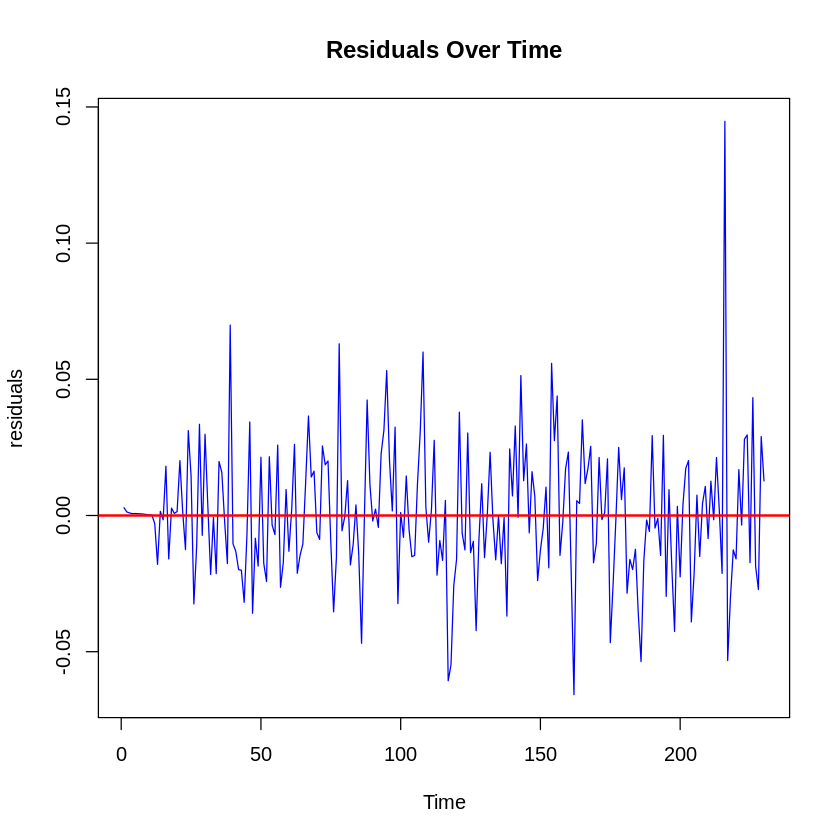

In [ ]:
residuals <- (residuals(sarima_model))
plot(residuals, type="l", main="Residuals Over Time", col="blue")
abline(h=0, col="red", lwd=2)


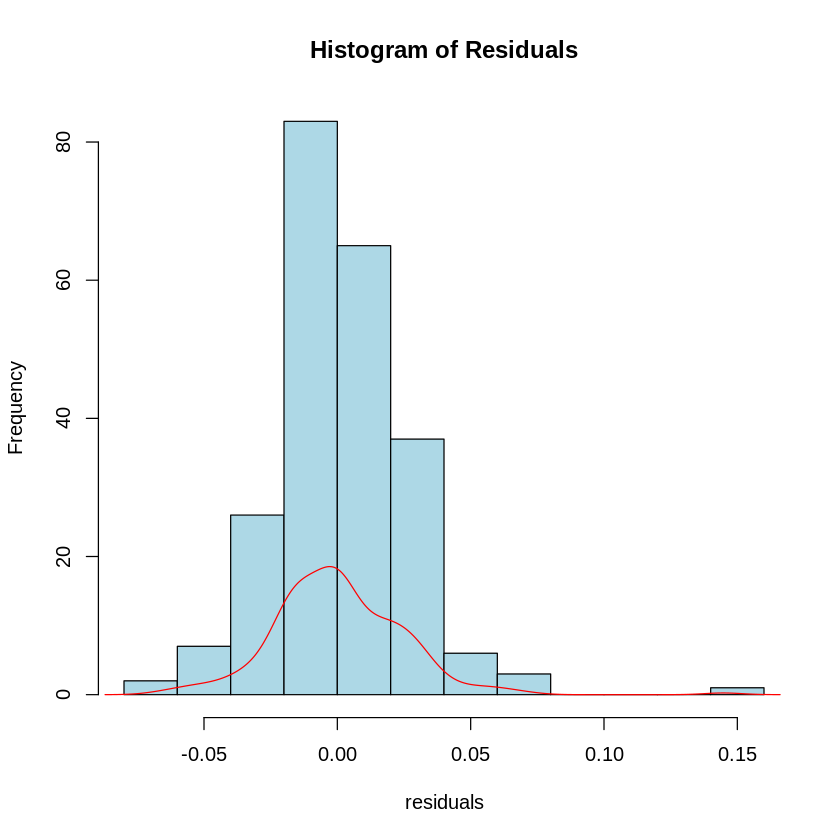

In [ ]:
hist(residuals, main="Histogram of Residuals", col="lightblue", breaks=10)
lines(density(residuals), col="red", lwd=1)

In [ ]:
shapiro.test(residuals)



	Shapiro-Wilk normality test

data:  residuals
W = 0.95, p-value = 3.93e-07


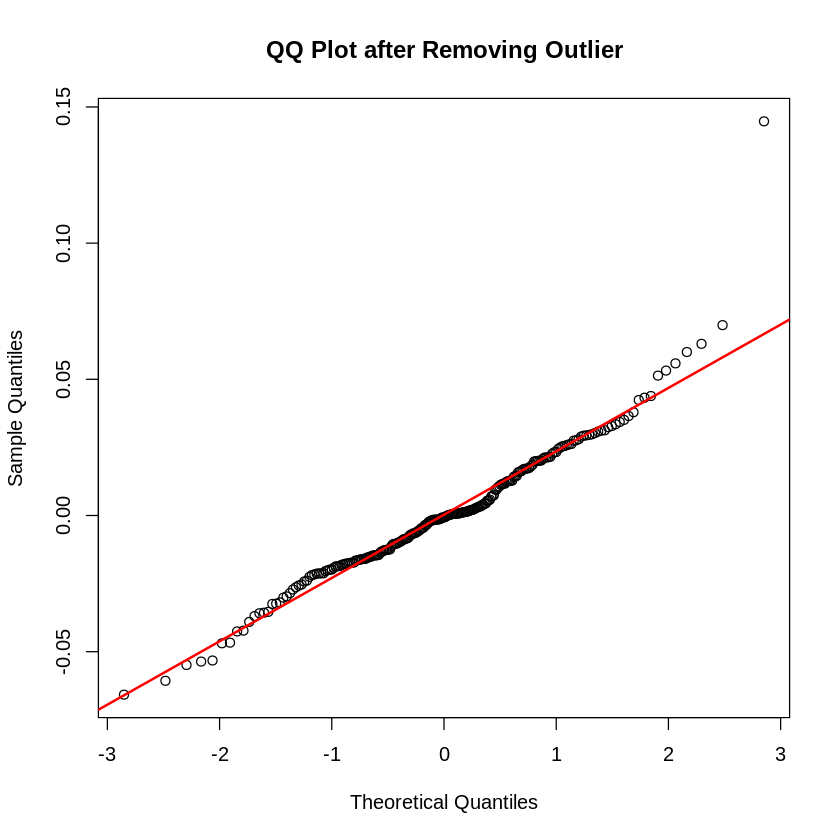

In [ ]:


qqnorm(residuals, main="QQ Plot after Removing Outlier")
qqline(residuals, col="red", lwd=2)


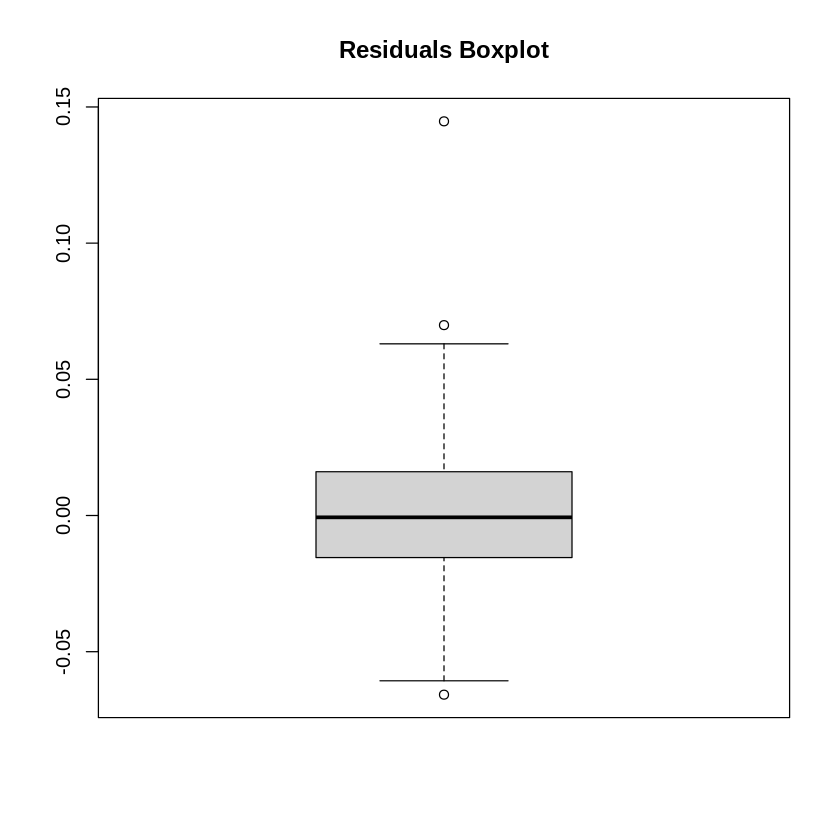

In [ ]:
boxplot(residuals(sarima_model), main="Residuals Boxplot")


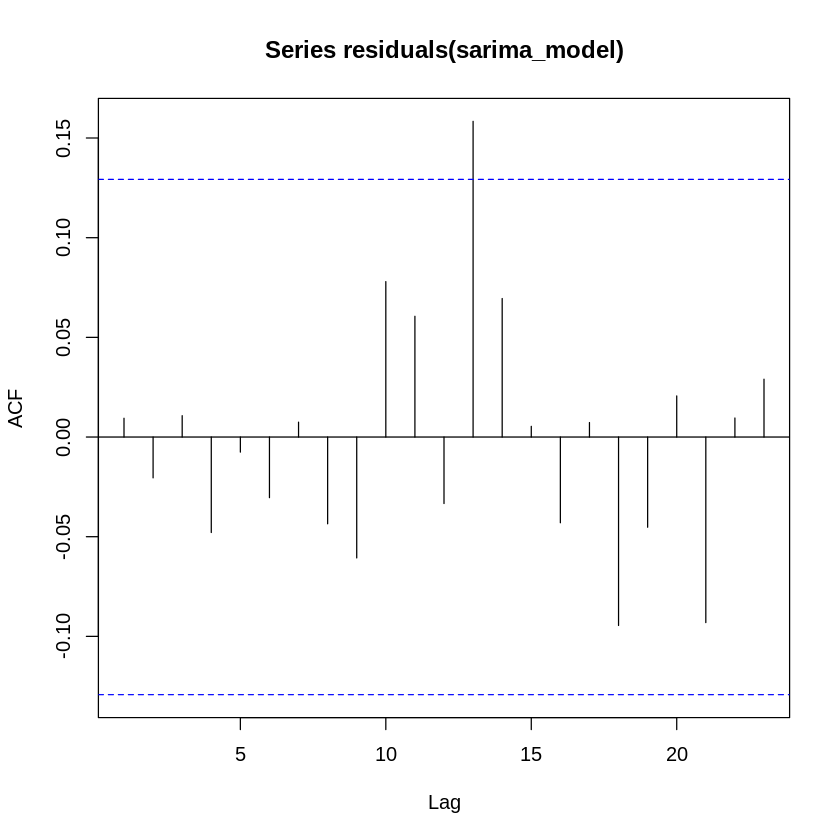

In [ ]:
acf(residuals(sarima_model))


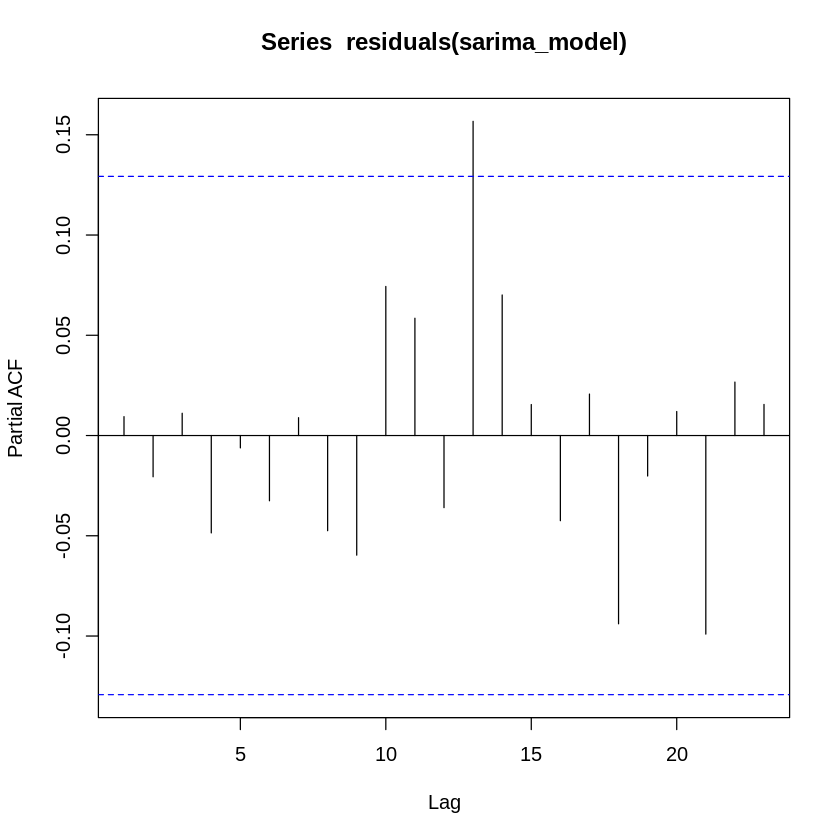

In [ ]:
pacf(residuals(sarima_model))

In [ ]:
Box.test(residuals(sarima_model), lag=10, type="Ljung-Box")



	Box-Ljung test

data:  residuals(sarima_model)
X-squared = 3.7518, df = 10, p-value = 0.9578


In [ ]:
library(forecast)
library(tseries)


residuals_sarima <- residuals(sarima_model)


residuals_sign <- ifelse(residuals_sarima > 0, 1, 0)


runs_test_result <- runs.test(factor(residuals_sign))

print(runs_test_result)




	Runs Test

data:  factor(residuals_sign)
Standard Normal = -0.65093, p-value = 0.5151
alternative hypothesis: two.sided



from above we can conclude that the residual are indipendent from the plot and the run test which is good so our model captures well the dependence
adding to that our residuals have no autocorolation or paritial autocorelation since for lags it is between the bands so
we can say it is = 0
but the residual are not normal as we can see

1.   in the Histogram their is an aditional quantity at the top right which may implies no normality
2.   the shapiro test also tell that the residuals are not normal since p < 0.05
3.   in the qq plot the point are not aligned perfectly with the line which  indicate that they are not strictly normal

(note the non normality is caused by the small bar in the top right of the histogram and can be just an outlier in our data )

the Ljung-Box test which is a formal test for white noise tell us that the residual are white noise since p_value=0.957 > 0.05


**so as a conclusion our residuals are stationary , their is no autocorelation or partiel autocorrelation between them and they are white noise but te other method say that they are not normal so their is still work to improve our model  and try to make the residuals normaly distributed but it is still a good one **

note some assemption made by the r functions may be false since the residuals are not normal so we cant say a lot





[1] "RMSE :  6182.54527665063"
[1] "MAPE: 9.84 %"
[1] "mae 4044.54568109321"


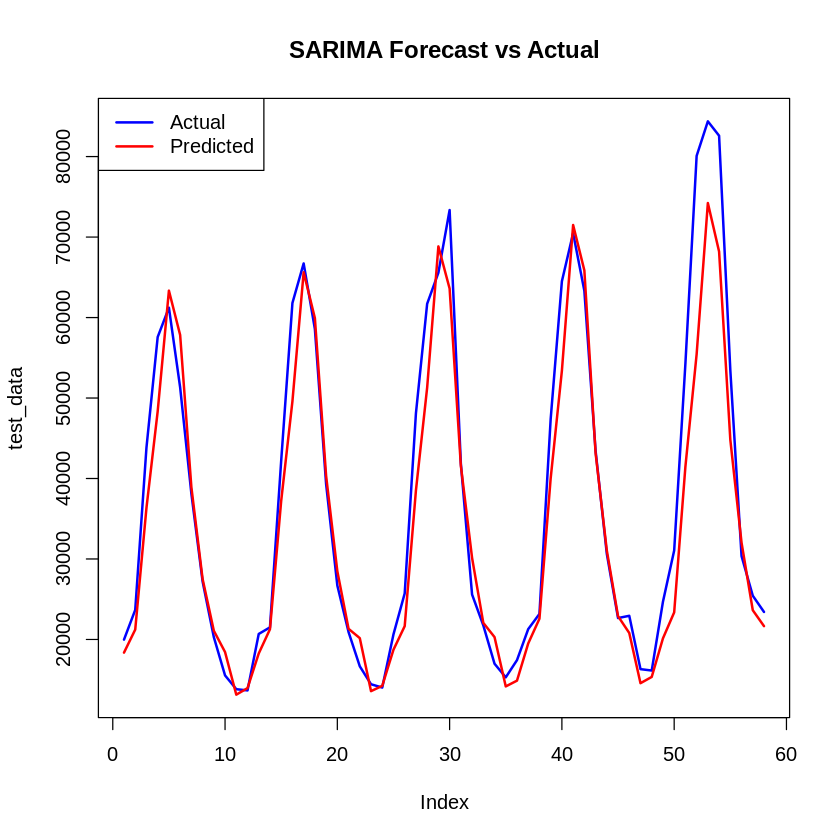

In [ ]:

forecast_horizon <- length(test_data)
sarima_forecast <- forecast(sarima_model, h = forecast_horizon)

# Inverse Box-Cox
predicted_values <- InvBoxCox(sarima_forecast$mean, lambda)


mape_value <- mape(test_data, predicted_values)
print(paste("RMSE : ", rmse(test_data, predicted_values)))
print(paste("MAPE:", round(mape_value * 100, 2), "%"))
print(paste("mae",mae(test_data, predicted_values)))


plot(test_data, col="blue", type="l", lwd=2, main="SARIMA Forecast vs Actual",
     ylim = range(c(test_data, predicted_values)))  # Ensure both fit in the plot
lines(seq_along(test_data), predicted_values, col="red", lwd=2)  # Align x-axis
legend("topleft", legend=c("Actual", "Predicted"), col=c("blue", "red"), lwd=2)

eveluation of model performance

Root Mean Squared Error (RMSE): 6,182.55​

Mean Absolute Percentage Error (MAPE): 9.84%​

Mean Absolute Error (MAE): 4,044.55​

These results indicate that my model is performing well. Additionally, the residuals are independent, suggesting that the model has effectively captured the underlying patterns in the data. However, I observed that the residuals deviate from normality, which affect certain statistical analyses but does not  undermine the model's predictive accuracy.

# using BIC

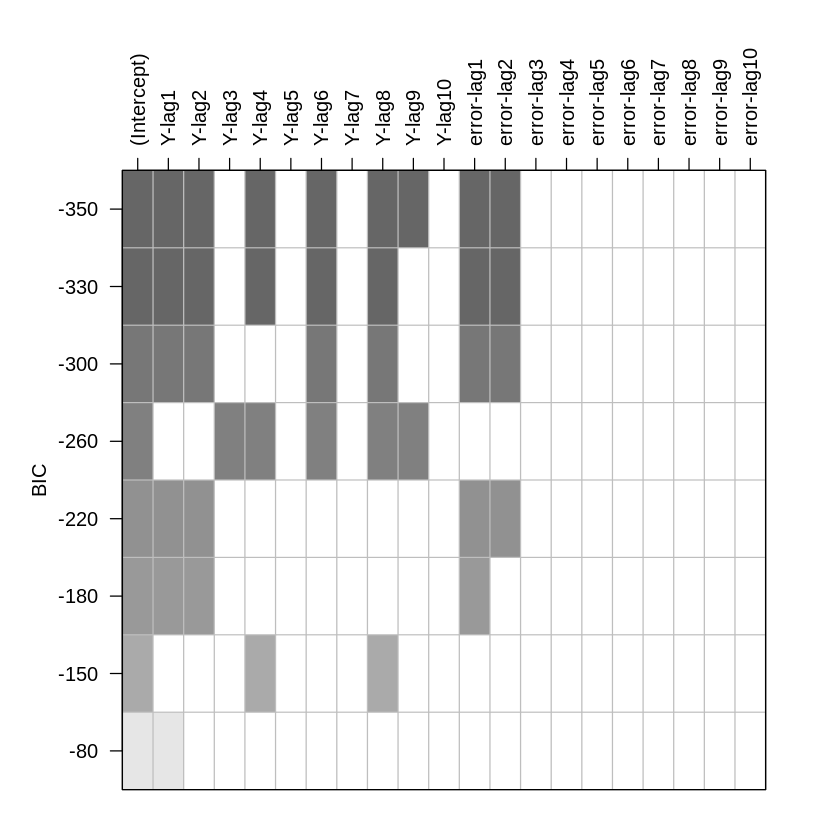

In [ ]:
library(TSA)

plot(armasubsets(diff(ts_data), 10, 10))

from the bic we can see that our model is a SARIMA(9,1,2) × (0,1,1)12s

In [ ]:

library(forecast)
library(tseries)
library(Metrics)

d <- 1


train_size <- round(0.8 * length(ts_data))
train_data <- ts_data[1:train_size]
test_data <- ts_data[(train_size + 1):length(ts_data)]

# Apply Box-Cox transformation
lambda <- BoxCox.lambda(train_data, method = "loglik")
train_data_bc <- BoxCox(train_data, lambda)
test_data_bc <- BoxCox(test_data, lambda)

p <- 9
q <- 2
P <- 0
D <- 1
Q <- 1
s <- 12


sarima_model_bic <- tryCatch({
  Arima(train_data_bc,
        order = c(p, d, q),
        seasonal = list(order = c(P, D, Q), period = s),
        method = "ML")
}, error = function(e) {
  message("Arima() failed, using auto.arima() as fallback")
  auto.arima(train_data_bc, seasonal = TRUE)
})



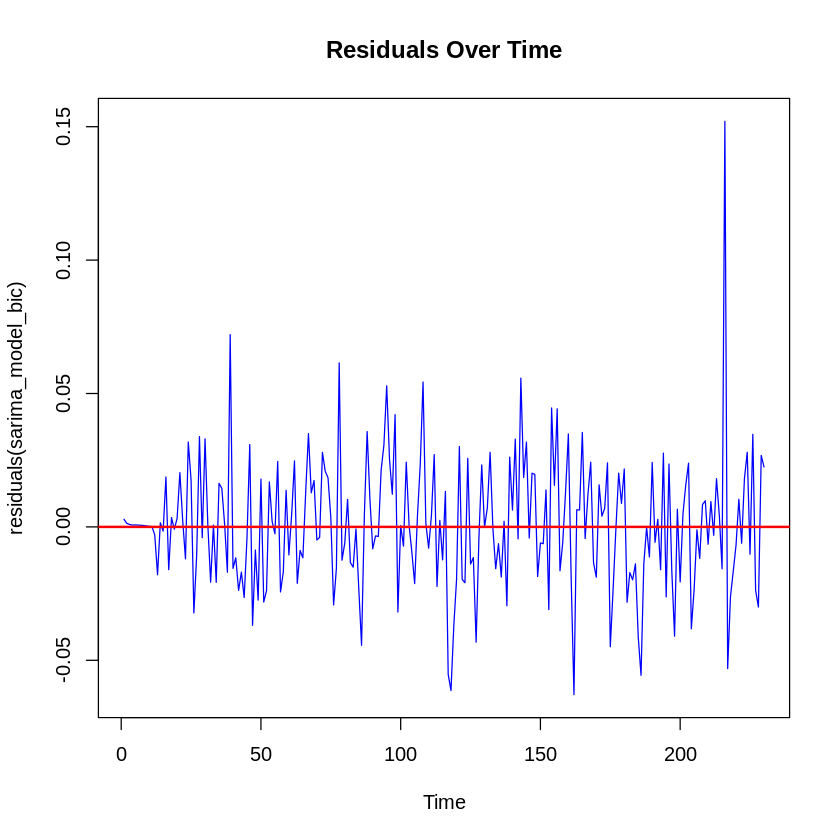

In [ ]:
residuals_sarima <- (residuals(sarima_model_bic)[-216])
plot(residuals(sarima_model_bic), type="l", main="Residuals Over Time", col="blue")
abline(h=0, col="red", lwd=2)



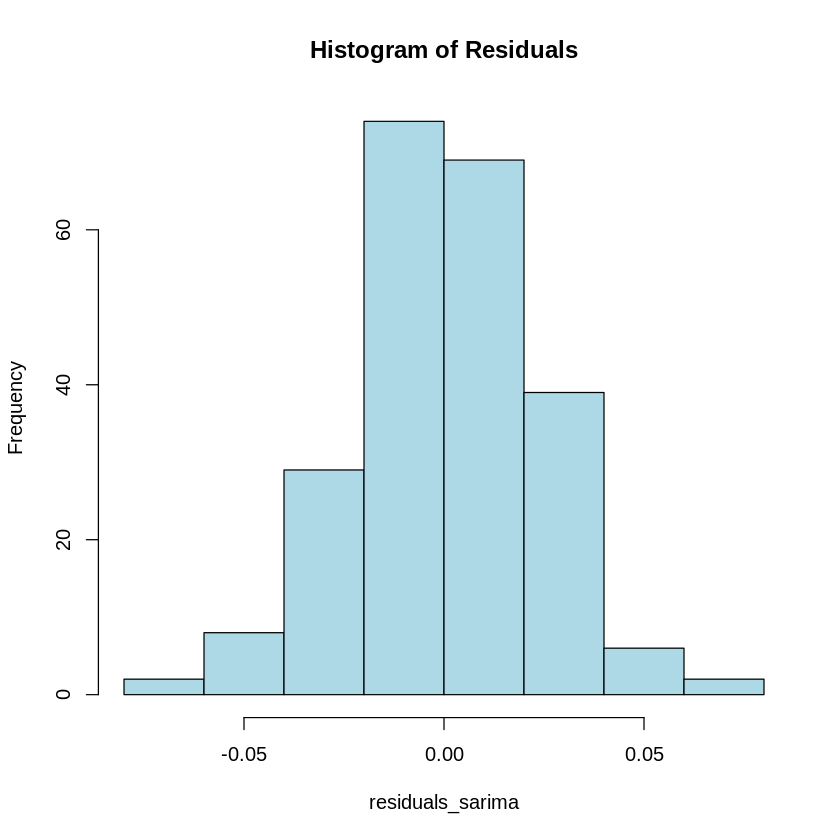

In [ ]:

hist(residuals_sarima, main="Histogram of Residuals", col="lightblue", breaks=7)


In [ ]:
shapiro.test(residuals_sarima)



	Shapiro-Wilk normality test

data:  residuals_sarima
W = 0.99368, p-value = 0.4446


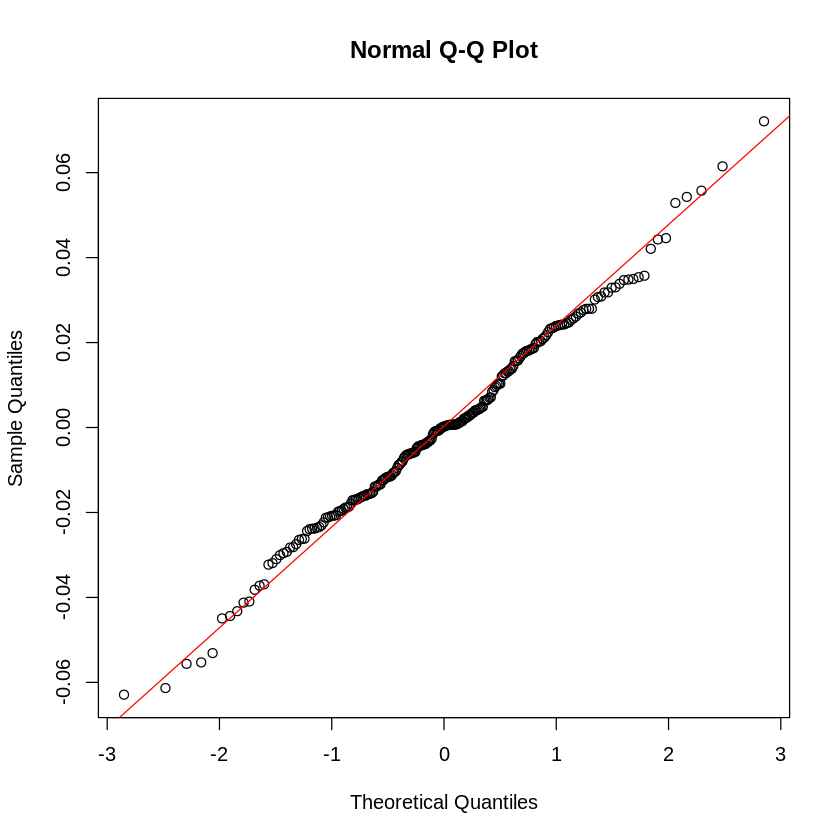

In [ ]:
qqnorm(residuals_sarima)
qqline(residuals_sarima, col="red")

In [ ]:
Box.test(residuals_sarima, lag=10, type="Ljung-Box")



	Box-Ljung test

data:  residuals_sarima
X-squared = 5.0713, df = 10, p-value = 0.8864


In [ ]:
library(forecast)
library(tseries)

residuals_sign <- ifelse(residuals_sarima > 0, 1, 0)


runs_test_result <- runs.test(factor(residuals_sign))

print(runs_test_result)




	Runs Test

data:  factor(residuals_sign)
Standard Normal = -0.32859, p-value = 0.7425
alternative hypothesis: two.sided



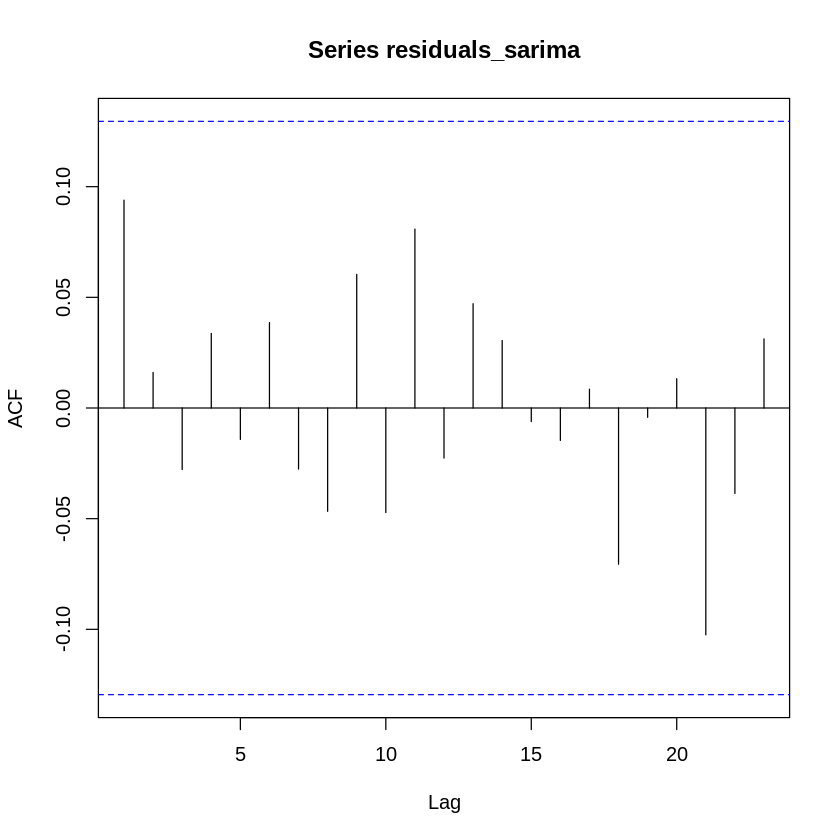

In [ ]:
acf(residuals_sarima)

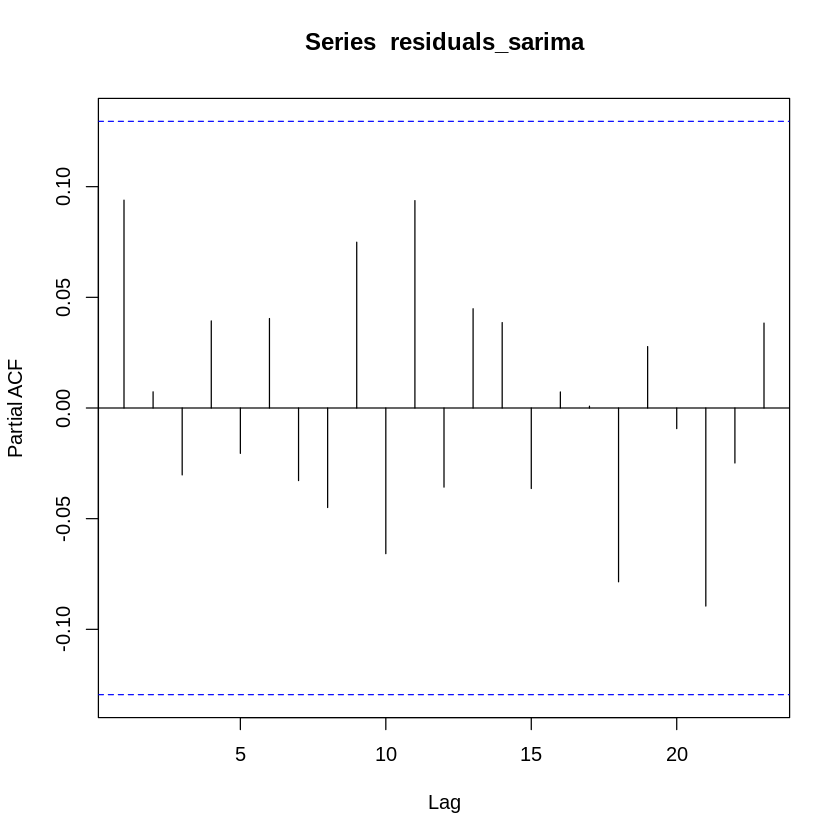

In [ ]:
pacf(residuals_sarima)

from the plot of residual we can see that they are random
and the run test confirm it (p = 0.7425 > 0.05) along with the acf and pacf plot wich indicate 0 autocorelation and partiel autocorelation so our residuals are indepandent so the model captures the dependense in a good way

 the histogram seams to follow a normal low which may indicate that the residual are normal distributed
the qq plot in his side confirm this hypothese since the point  accord well with the line
 and with the p_value =0.44 > 0.05 of the shapiro test we are sure that our residuale are normaly distributed
the ljung test say that our residuals are white noise (p =0.9 > 0.05)

so here we can say that our model is performing good since we get that our residuals are indepandent and normaly distributed and white noise so this one is a good model

[1] "rmse: 5172"
[1] "MAPE: 8.97 %"
[1] "mae: 3687"


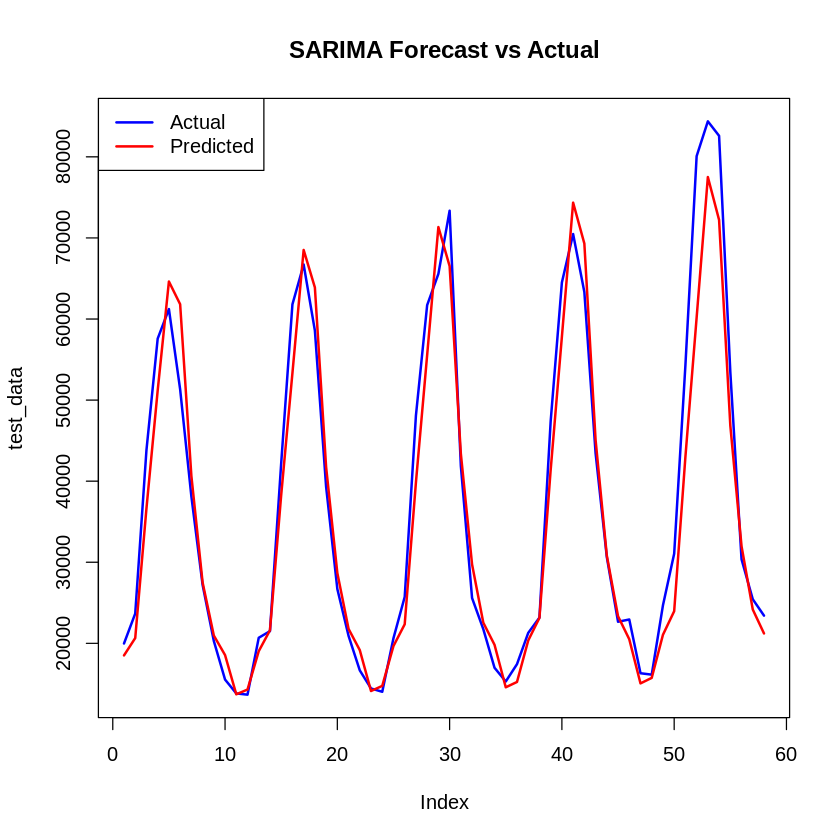

In [ ]:

forecast_horizon <- length(test_data)
sarima_forecast <- forecast(sarima_model_bic, h = forecast_horizon)

# Inverse Box-Cox
predicted_values <- InvBoxCox(sarima_forecast$mean, lambda)


mape_value <- mape(test_data, predicted_values)
print(paste("rmse:", round(rmse(test_data, predicted_values))))
print(paste("MAPE:", round(mape_value * 100, 2), "%"))
print(paste("mae:", round(mae(test_data, predicted_values))))


plot(test_data, col="blue", type="l", lwd=2, main="SARIMA Forecast vs Actual",
     ylim = range(c(test_data, predicted_values)))  # Ensure both fit in the plot
lines(seq_along(test_data), predicted_values, col="red", lwd=2)  # Align x-axis
legend("topleft", legend=c("Actual", "Predicted"), col=c("blue", "red"), lwd=2)

our performance has increased compared to before as our model fit well the test set and the metrics improved

# using auto arima  
(to see if we can get better forcast result )

In [ ]:

library(forecast)
library(tseries)
library(Metrics)

# Split data into train (80%) and test (20%)
train_size <- round(0.8 * length(ts_data))
train_data <- ts_data[1:train_size]
test_data <- ts_data[(train_size + 1):length(ts_data)]


lambda <- BoxCox.lambda(train_data, method = "loglik")
train_data_bc <- BoxCox(train_data, lambda)
test_data_bc <- test_data

sarima_model_bic <-  auto.arima(train_data_bc, seasonal = TRUE)

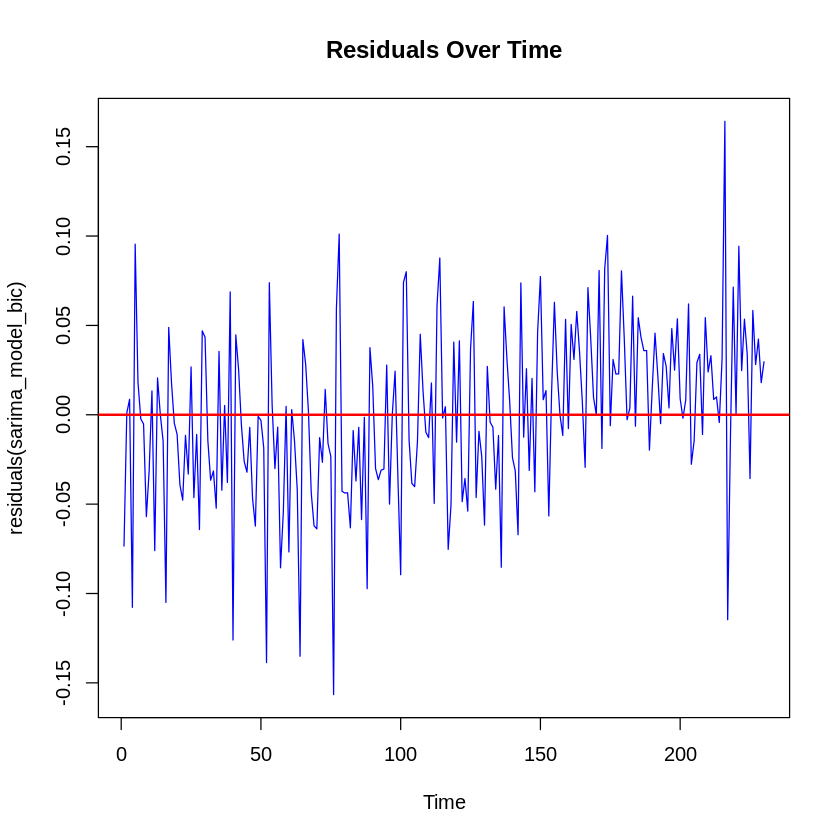

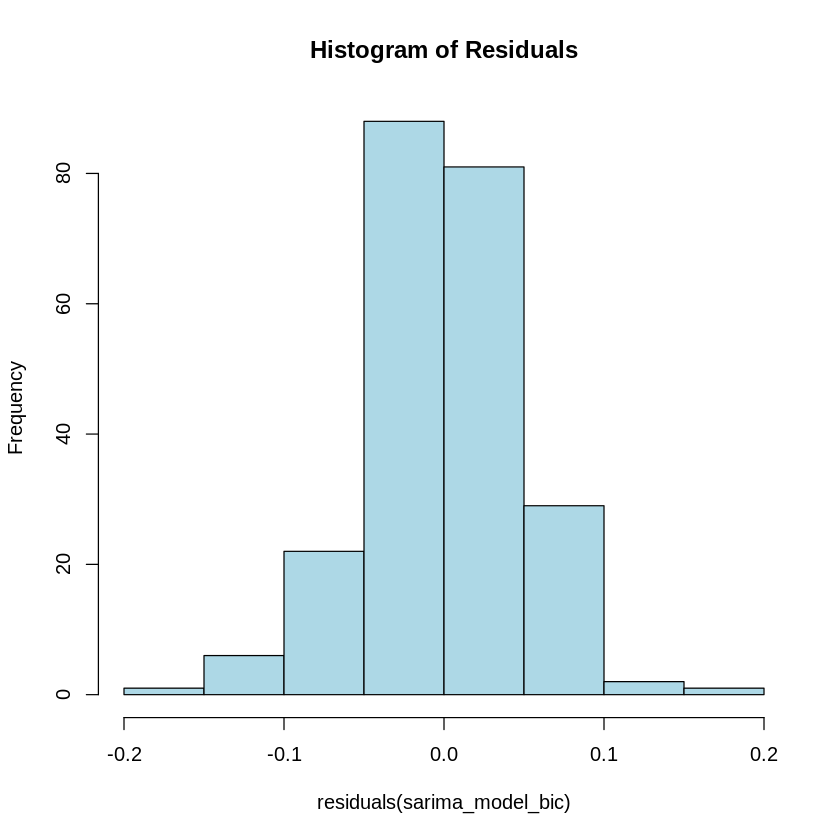


	Shapiro-Wilk normality test

data:  residuals(sarima_model_bic)
W = 0.99127, p-value = 0.1853



	Runs Test

data:  factor(residuals_sign)
Standard Normal = -2.1107, p-value = 0.0348
alternative hypothesis: two.sided




	Box-Ljung test

data:  residuals(sarima_model_bic)
X-squared = 197.44, df = 20, p-value < 2.2e-16


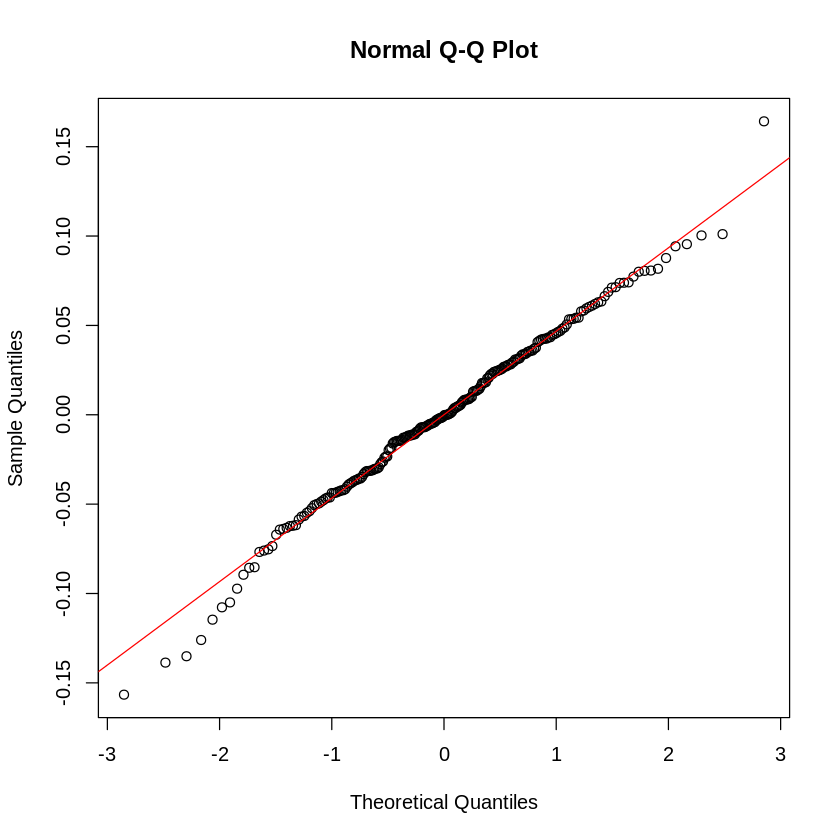

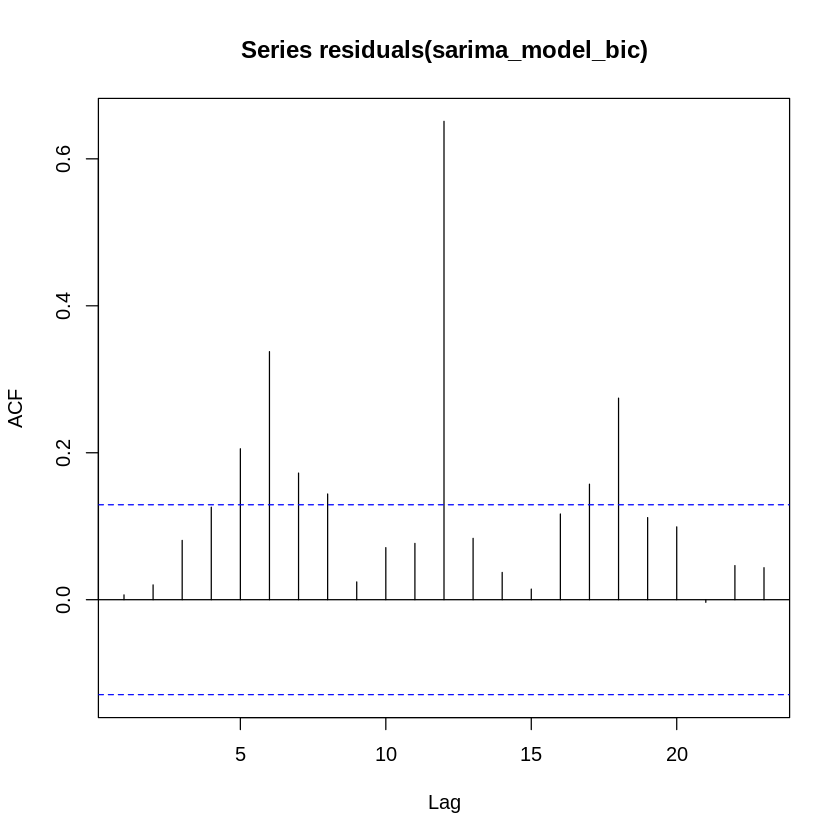

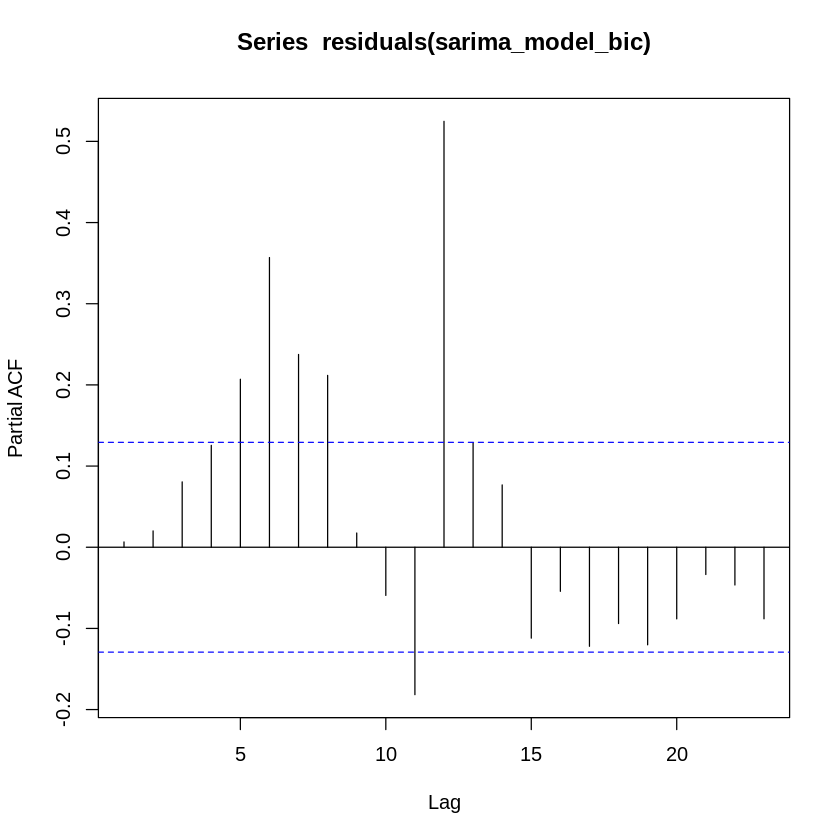

In [ ]:
plot(residuals(sarima_model_bic), type="l", main="Residuals Over Time", col="blue")
abline(h=0, col="red", lwd=2)


hist(residuals(sarima_model_bic), main="Histogram of Residuals", col="lightblue", breaks=7)

qqnorm(residuals(sarima_model_bic))
qqline(residuals(sarima_model_bic), col="red")

shapiro.test(residuals(sarima_model_bic))

residuals_sarima <- residuals(sarima_model_bic)


residuals_sign <- ifelse(residuals_sarima > 0, 1, 0)


runs_test_result <- runs.test(factor(residuals_sign))


print(runs_test_result)
Box.test(residuals(sarima_model_bic), lag=20, type="Ljung-Box")
acf(residuals(sarima_model_bic))
pacf(residuals(sarima_model_bic))


here we get the inverse our residuals are normal but not indepandent and there is still correlation that the model didnt capture as it is shown in the acf and pacf
and it is clearly not a white noise as ljung present

those assemption can clearly be seen in the plot of residuals were they are increasing

so this model fail to capture best parameter

[1] "MAPE: 33.71 %"


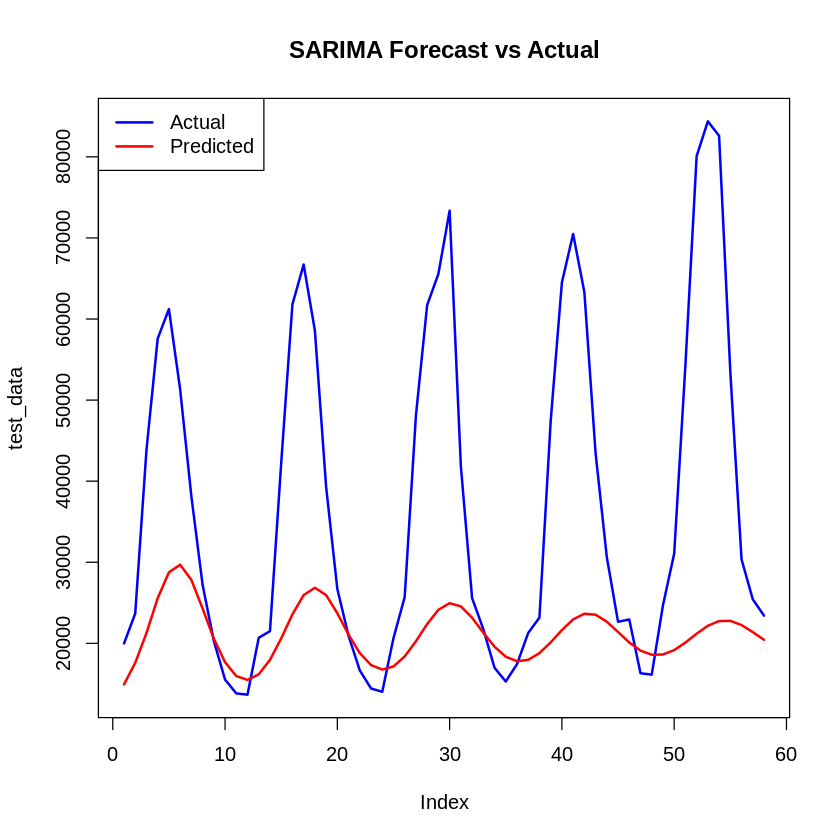

In [ ]:


forecast_horizon <- length(test_data)
sarima_forecast <- forecast(sarima_model_bic, h = forecast_horizon)


predicted_values <- InvBoxCox(sarima_forecast$mean, lambda)

mape_value <- mape(test_data, predicted_values)
print(paste("MAPE:", round(mape_value * 100, 2), "%"))


plot(test_data, col="blue", type="l", lwd=2, main="SARIMA Forecast vs Actual",
     ylim = range(c(test_data, predicted_values)))  # Ensure both fit in the plot
lines(seq_along(test_data), predicted_values, col="red", lwd=2)  # Align x-axis
legend("topleft", legend=c("Actual", "Predicted"), col=c("blue", "red"), lwd=2)

*conclusion on th mdels*

after testing all the model with all possible ways we see that the best model with the best prediction is ARIMA(9,1,2)(0,1,1)[12] which have a mape valus of 8.97 and an indepandent normal residuals (white noise )


# using our best model to forcast 1 year a head
ARIMA(9 1 2)(0 1 1)[12]

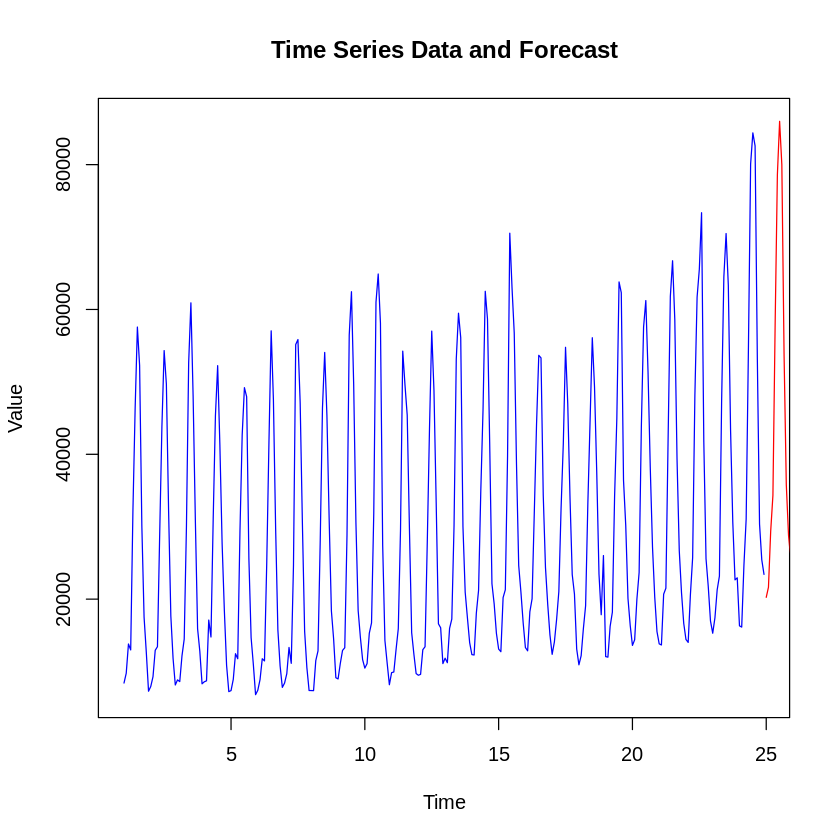

In [ ]:

library(forecast)
library(tseries)
library(Metrics)


d <- ndiffs(ts_data)
if (d < 2) d <- 1




lambda <- 0.5
train_data_bc <- BoxCox(ts_data, lambda)




p <- 9
q <- 2
P <- 0
D <- 1
Q <- 1
s <- 12


sarima_model_bic <- tryCatch({
  Arima(train_data_bc,
        order = c(p, d, q),
        seasonal = list(order = c(P, D, Q), period = s),
        method = "ML")
}, error = function(e) {
  message("Arima() failed, using auto.arima() as fallback")
  auto.arima(train_data_bc, seasonal = TRUE)
})


best_forecast <- forecast(sarima_model_bic, h=12)

best_forecast$mean <- InvBoxCox(best_forecast$mean, lambda)



plot(ts_data, col = 'blue', type = 'l', ylim = range(c(ts_data, best_forecast$mean)),
     main = "Time Series Data and Forecast", ylab = "Value", xlab = "Time")

lines(best_forecast$mean, col = 'red', type = 'l')

As we can see, our forecast appears to be accurate and can be used to anticipate the arrival of tourists for the next year. This information helps in preparation and maximizing the benefits, as local people primarily earn money from tourism.

#Discussion
What I Did
I identified the best SARIMA model using BIC, ACF, PACF, and auto.arima(). Additionally, I tested looping through parameter combinations, but it was unnecessary since it took too long and gave the same result. I also see some other time series model like prophet and machine learning like randomforest regressor but the better result was still obtained by the sarima models

Challenges
The main difficulty was finding a model with normally distributed residuals. Apart from that, there were no major issues.

